# Exploratory Data Analysis

In [1]:
# Importing necessay packages

sc.stop()
import sys
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import format_string
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import col, avg
from pyspark.sql import functions as F
                             
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.classification import SVMWithSGD
!pip install plotly
!pip install cufflinks

from pyspark.sql import DataFrame
!HADOOP_LIBPATH='/opt/cloudera/parcels/CDH/lib'
!HADOOP_STREAMING='hadoop-mapreduce/hadoop-streaming.jar'

!alias hfs="$HADOOP_EXE fs"

sc = SparkContext()
spark = SparkSession(sc)

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/1a/18/4d32edaaf31ba4af9745dac676c4a28c48d3fc539000c29e855bd8db3b86/cufflinks-0.17.3.tar.gz
  Using cached https://files.pythonhosted.org/packages/9a/53/f696e4480b1d1de3b1523991dea71cf417c8b19fe70c704da164f3f90972/colorlover-0.3.0-py3-none-any.whl
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/share/apps/python/3.6.5/lib/python3.6/site-packages/colorlover'
Consider using the `--user` option or check the permissions.

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

In [3]:
# Unzipping the Dataset zip file

!unzip './the-movies-dataset.zip'

Archive:  ./the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


In [4]:
# Moving the data files to HDFS

!hadoop fs -put credits.csv
!hadoop fs -put keywords.csv
!hadoop fs -put links.csv
!hadoop fs -put links_small.csv
!hadoop fs -put movies_metadata.csv
!hadoop fs -put ratings.csv
!hadoop fs -put ratings_small.csv


put: `credits.csv': File exists
put: `keywords.csv': File exists
put: `links.csv': File exists
put: `links_small.csv': File exists
put: `movies_metadata.csv': File exists
put: `ratings.csv': File exists
put: `ratings_small.csv': File exists


## Data Cleaning Steps (common to all EDA tasks)

In [5]:
# Reading Movies Metadata file to a spark dataframe

df_movies_metadata = spark.read.format("csv").option("header","true").load("movies_metadata.csv")
df_movies_metadata.head()

Row(adult='False', belongs_to_collection="{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}", budget='30000000', genres="[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]", homepage='http://toystory.disney.com/toy-story', id='862', imdb_id='tt0114709', original_language='en', original_title='Toy Story', overview="Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.", popularity='21.946943', poster_path='/rhIRbceoE9lR4veEXuwCC2wARtG.jpg', production_companies="[{'name': 'Pixar Animation Studios', 'id': 3}]", production_countries="[{'iso_3166_1': 'US', 'name': 'United States of America'}]", releas

In [6]:
# Columns of Movies-Metadata

df_movies_metadata.columns

['adult',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count']

In [7]:
# Number of Entries in Movies-meta data

print("Number of Entries in Meta data dataframe:",df_movies_metadata.count())

Number of Entries in Meta data dataframe: 45572


In [8]:
# Column datatypes of movies_metadata dataframe
#CHANGE: to show the describe elements
df_movies_metadata.describe().show()

+-------+-------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+------------------+------------------+--------------------+
|summary|              adult|belongs_to_collection|              budget|              genres|            homepage|                  id|             imdb_id| original_language|    original_title|            overview|          popularity|         poster_path|production_companies|production_countries|        release_date|             revenue|             runtime|    spoken_languages|              status|             tagline|   title|             video|      vote_average|          vote_count|
+-------+---

In [9]:
# Data Cleaning

# Dropping Unnecessary columns (imdb_id)

df_movies_metadata = df_movies_metadata.drop("imdb_id")

# Removing original_title and retaining the translated title
#CHANGED THE BELOW LINE to only show the rows where the title and original title are different
df_movies_metadata.select(["original_title","title"]).filter("original_title!=title").show(10)

df_movies_metadata = df_movies_metadata.drop("original_title")

# Updated Columns of Movies-Metadata

df_movies_metadata.columns

+--------------------+--------------------+
|      original_title|               title|
+--------------------+--------------------+
|   Waiting to Exhale|[{'iso_639_1': 'e...|
|          Get Shorty|               105.0|
|La Cité des Enfan...| {'name': 'Victoi...|
|           摇啊摇，摇到外婆桥|      Shanghai Triad|
|Guillaumet, les a...|    Wings of Courage|
|     Dead Presidents|[{'iso_639_1': 'e...|
|               Se7en|[{'iso_639_1': 'e...|
|          Il postino|         The Postman|
|    Le confessionnal|    The Confessional|
|            Bio-Dome|Bud and Doyle are...|
+--------------------+--------------------+
only showing top 10 rows



['adult',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'id',
 'original_language',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count']

In [10]:
# Presence of Zero-revenue movies
print("Before replacing Zero values")
df_movies_metadata.select("revenue","budget").show()

print("Number of Movie records with Revenue as 0")
print(df_movies_metadata.filter(df_movies_metadata.revenue=='0').count())

print("After replacing Zero values")
df_movies_metadata = df_movies_metadata.withColumn("revenue", df_movies_metadata["revenue"].cast(IntegerType()))
df_movies_metadata = df_movies_metadata.withColumn("revenue", F.when(F.col("revenue").isNull(), np.nan).otherwise(F.col("revenue")))
df_movies_metadata = df_movies_metadata.withColumn("revenue", F.when(F.col("revenue")=='0', np.nan).otherwise(F.col("revenue")))
df_movies_metadata.select(["revenue","budget"]).show()

Before replacing Zero values
+--------------------+--------+
|             revenue|  budget|
+--------------------+--------+
|           373554033|30000000|
|           262797249|65000000|
|                   0|       0|
|[{'name': 'Twenti...|16000000|
|            76578911|       0|
|           187436818|60000000|
|                   0|58000000|
|                   0|       0|
|            64350171|35000000|
|           352194034|58000000|
|           107879496|62000000|
|                   0|       0|
|            11348324|       0|
|            13681765|44000000|
|            10017322|98000000|
|           116112375|52000000|
|           135000000|16500000|
|             4300000| 4000000|
|           212385533|30000000|
|            35431113|60000000|
+--------------------+--------+
only showing top 20 rows

Number of Movie records with Revenue as 0
34799
After replacing Zero values
+------------+--------+
|     revenue|  budget|
+------------+--------+
|3.73554033E8|30000000|
|2.62

In [11]:
# Casting Budget to IntegerType and replacing zero budget entries to NaN

df_movies_metadata = df_movies_metadata.withColumn("budget", df_movies_metadata["budget"].cast(IntegerType()))
#CHANGE: 1 line
df_movies_metadata.describe("budget").show()

df_movies_metadata = df_movies_metadata.withColumn("budget", F.when(F.col("budget")==0, np.nan).otherwise(F.col("budget")))
df_movies_metadata.select("budget").show()

#CHANGE: 1 line.
df_movies_metadata.describe("budget").show()


+-------+-------------------+
|summary|             budget|
+-------+-------------------+
|  count|              45370|
|   mean|  4203051.501212255|
| stddev|1.739038821328166E7|
|    min|                  0|
|    max|          380000000|
+-------+-------------------+

+---------+
|   budget|
+---------+
|    3.0E7|
|    6.5E7|
|      NaN|
|    1.6E7|
|      NaN|
|    6.0E7|
|    5.8E7|
|      NaN|
|    3.5E7|
|    5.8E7|
|    6.2E7|
|      NaN|
|      NaN|
|    4.4E7|
|    9.8E7|
|    5.2E7|
|   1.65E7|
|4000000.0|
|    3.0E7|
|    6.0E7|
+---------+
only showing top 20 rows

+-------+------+
|summary|budget|
+-------+------+
|  count| 45370|
|   mean|   NaN|
| stddev|   NaN|
|    min|   1.0|
|    max|   NaN|
+-------+------+



In [12]:
# Creating a New column called Return : (Revenue/Budget) to assess the success of movies

df_movies_metadata = df_movies_metadata.withColumn("return",df_movies_metadata["revenue"]/df_movies_metadata["budget"])
df_movies_metadata.select(["revenue","budget","return"]).show()

+------------+---------+-------------------+
|     revenue|   budget|             return|
+------------+---------+-------------------+
|3.73554033E8|    3.0E7|         12.4518011|
|2.62797249E8|    6.5E7|          4.0430346|
|         NaN|      NaN|                NaN|
|         NaN|    1.6E7|                NaN|
| 7.6578911E7|      NaN|                NaN|
|1.87436818E8|    6.0E7|  3.123946966666667|
|         NaN|    5.8E7|                NaN|
|         NaN|      NaN|                NaN|
| 6.4350171E7|    3.5E7| 1.8385763142857143|
|3.52194034E8|    5.8E7|  6.072310931034483|
|1.07879496E8|    6.2E7|  1.739991870967742|
|         NaN|      NaN|                NaN|
| 1.1348324E7|      NaN|                NaN|
| 1.3681765E7|    4.4E7|0.31094920454545455|
| 1.0017322E7|    9.8E7|0.10221757142857144|
|1.16112375E8|    5.2E7| 2.2329302884615383|
|      1.35E8|   1.65E7|  8.181818181818182|
|   4300000.0|4000000.0|              1.075|
|2.12385533E8|    3.0E7|  7.079517766666667|
| 3.543111

In [13]:
# Extracting and creating a year column from release date of movie 
df_movies_metadata = df_movies_metadata.withColumn("year", year(df_movies_metadata["release_date"]).alias('year'))

In [14]:
# Dropping Adult column as very few movies qualify as Adult

print("Number of Adult Movies:",df_movies_metadata.filter(df_movies_metadata["adult"]==True).select("adult").count())
print("Therefore,we can safely remove that column")
df_movies_metadata = df_movies_metadata.drop("adult")


Number of Adult Movies: 9
Therefore,we can safely remove that column


## Budget Analysis

+-------+--------------------+
|summary|              budget|
+-------+--------------------+
|  count|                8851|
|   mean|2.1544734675177947E7|
| stddev| 3.430310086924772E7|
|    min|                 1.0|
|    max|               3.8E8|
+-------+--------------------+



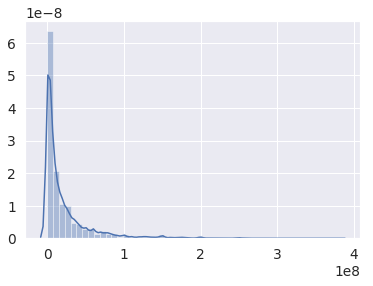

In [15]:
#Budget Analysis
#Insights from Summary Statistics
df_movies_metadata.filter(isnan(df_movies_metadata['budget'])==False).describe("budget").show()

sns.distplot(df_movies_metadata.filter((isnan(df_movies_metadata['budget'])==False) & (df_movies_metadata['budget'].isNotNull())).select('budget').collect())

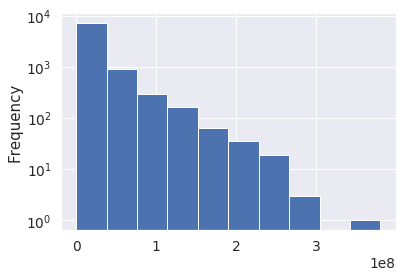

In [16]:
#The distribution of movie budgets shows an exponential decay below
# .collect().plot(logy=True, kind='hist')
t = df_movies_metadata.toPandas()
t['budget'].plot(logy=True, kind='hist')

In [17]:
#Most Expensive Movies of all Time
a = df_movies_metadata.filter(isnan(df_movies_metadata['budget'])==False).select('title', 'budget', 'revenue', 'return', 'year').orderBy('budget', ascending=False)
a.show()

+--------------------+------+-------------+-------------------+----+
|               title|budget|      revenue|             return|year|
+--------------------+------+-------------+-------------------+----+
|Pirates of the Ca...| 3.8E8|1.045713802E9| 2.7518784263157894|2011|
|Pirates of the Ca...| 3.0E8|       9.61E8|  3.203333333333333|2007|
|Avengers: Age of ...| 2.8E8|1.405403694E9|  5.019298907142857|2015|
|    Superman Returns| 2.7E8| 3.91081192E8| 1.4484488592592593|2006|
|Transformers: The...| 2.6E8| 6.04942143E8|         2.32670055|2017|
|         John Carter| 2.6E8|   2.841391E8| 1.0928426923076924|2012|
|             Tangled| 2.6E8| 5.91794936E8| 2.2761343692307694|2010|
|        Spider-Man 3|2.58E8| 8.90871626E8| 3.4529907984496124|2007|
|     The Lone Ranger|2.55E8|   8.928991E7|0.35015650980392155|2013|
|Harry Potter and ...| 2.5E8| 9.54305868E8|        3.817223472|2010|
|The Hobbit: The D...| 2.5E8|      9.584E8|             3.8336|2013|
|The Hobbit: An Un...| 2.5E8|1.021

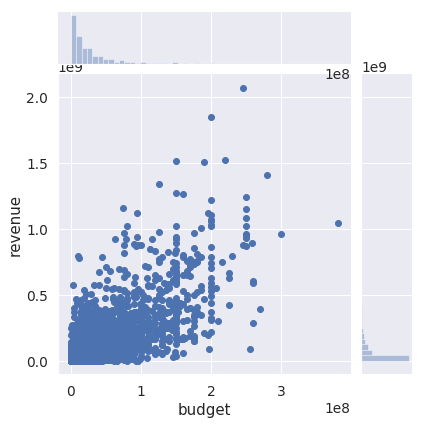

In [18]:
test = df_movies_metadata.filter(df_movies_metadata['return'].isNotNull()).toPandas()
sns.jointplot(x='budget',y='revenue',data=test)

## Revenue Analysis

+-------+--------------------+
|summary|             revenue|
+-------+--------------------+
|  count|                6937|
|   mean| 6.728491089217241E7|
| stddev|1.4331653639426452E8|
|    min|                 1.0|
|    max|       2.068223624E9|
+-------+--------------------+



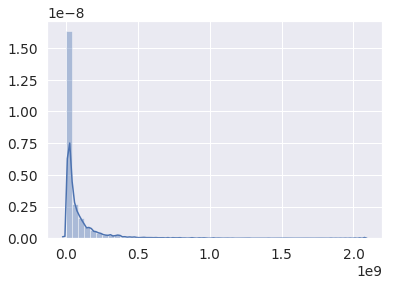

In [19]:
#13) Revenue Analysis
#Insights from Summary Statistics
df_movies_metadata.filter(isnan(df_movies_metadata['revenue'])==False).describe("revenue").show()

sns.distplot(df_movies_metadata.filter((isnan(df_movies_metadata['revenue'])==False) & (df_movies_metadata['revenue'].isNotNull())).select('revenue').collect())

In [20]:
#Highest Grossing Films of All Time
gross_top = df_movies_metadata.filter(isnan(df_movies_metadata['revenue'])==False).select('title', 'budget', 'revenue', 'year').orderBy('revenue', ascending=False)
gross_top.show()
# gross_top = gross_top.toPandas()
# HTML(gross_top.to_html(escape=False))

+--------------------+------+-------------+----+
|               title|budget|      revenue|year|
+--------------------+------+-------------+----+
|Star Wars: The Fo...|2.45E8|2.068223624E9|2015|
|             Titanic| 2.0E8|1.845034188E9|1997|
|        The Avengers| 2.2E8| 1.51955791E9|2012|
|      Jurassic World| 1.5E8| 1.51352881E9|2015|
|           Furious 7| 1.9E8| 1.50624936E9|2015|
|Avengers: Age of ...| 2.8E8|1.405403694E9|2015|
|Harry Potter and ...|1.25E8|      1.342E9|2011|
|              Frozen| 1.5E8|1.274219009E9|2013|
|Beauty and the Beast| 1.6E8|1.262886337E9|2017|
|The Fate of the F...| 2.5E8|1.238764765E9|2017|
|          Iron Man 3| 2.0E8|1.215439994E9|2013|
|             Minions| 7.4E7|1.156730962E9|2015|
|Captain America: ...| 2.5E8|1.153304495E9|2016|
|Transformers: Dar...|1.95E8|1.123746996E9|2011|
|The Lord of the R...| 9.4E7|1.118888979E9|2003|
|             Skyfall| 2.0E8|1.108561013E9|2012|
|The Dark Knight R...| 2.5E8|1.084939099E9|2012|
|         Toy Story 

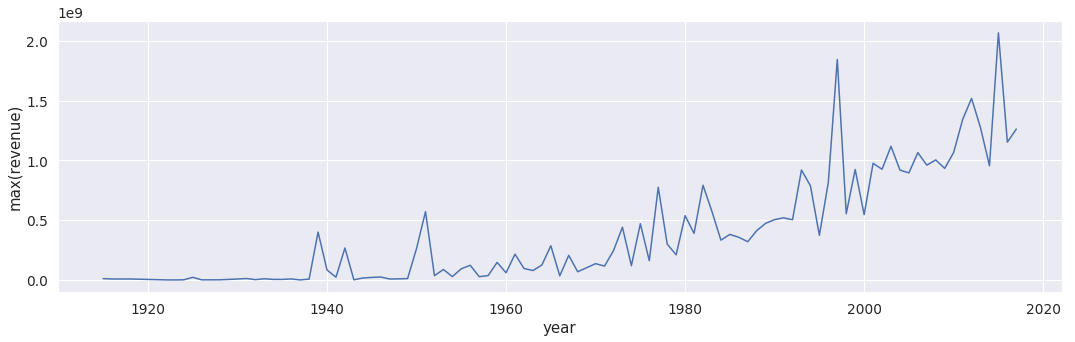

In [21]:
#Maximum revenue through the years
plt.figure(figsize=(18,5))
year_revenue = df_movies_metadata.filter(df_movies_metadata['revenue'].isNotNull() & isnan(df_movies_metadata['revenue'])==False)
year_revenue = year_revenue.filter(year_revenue['year'].isNotNull()).groupby('year')
year_revenue = year_revenue.max()
year_revenue = year_revenue.select('year','max(revenue)').sort('year')
t2 = year_revenue.toPandas()

sns.lineplot(x="year", y="max(revenue)", data=t2)

## Returns/Movie Success Analysis

In [22]:
#Returns or Movie Success Analysis 
#Most Successful Movies
print("Most Successful Movies:")
c = df_movies_metadata.filter((isnan(df_movies_metadata['return'])==False) & (df_movies_metadata['return'].isNotNull()) & (df_movies_metadata['budget'] > 5e6)).select('title', 'budget', 'revenue', 'return', 'year').orderBy('return', ascending=False)
c.show()

Most Successful Movies:
+--------------------+---------+------------+------------------+----+
|               title|   budget|     revenue|            return|year|
+--------------------+---------+------------+------------------+----+
|E.T. the Extra-Te...|   1.05E7|7.92965326E8| 75.52050723809523|1982|
|           Star Wars|    1.1E7|7.75398007E8| 70.49072790909091|1977|
|                Jaws|7000000.0|   4.70654E8| 67.23628571428571|1975|
|        The Exorcist|8000000.0|4.41306145E8|      55.163268125|1973|
|Four Weddings and...|6000000.0|2.54700832E8| 42.45013866666667|1994|
|       The Godfather|6000000.0|2.45066411E8|40.844401833333336|1972|
|           Annabelle|6500000.0|2.55273813E8|39.272894307692304|2014|
|       Dirty Dancing|6000000.0|2.13954274E8|35.659045666666664|1987|
|  The Sound of Music|8200000.0|2.86214286E8|34.904181219512196|1965|
|        Pretty Woman|    1.4E7|      4.63E8| 33.07142857142857|1990|
|    The Intouchables|    1.3E7|4.26480871E8| 32.80622084615385|20

In [23]:
#Worst Box Office Disasters
print("Worst Box Office Disasters:")
d = df_movies_metadata.filter((isnan(df_movies_metadata['return'])==False) & (df_movies_metadata['return'].isNotNull()) & (df_movies_metadata['budget'] > 5e6) & (df_movies_metadata['revenue'] > 10000)).select('title', 'budget', 'revenue', 'return', 'year').orderBy('return')
d.show()

Worst Box Office Disasters:
+--------------------+---------+--------+--------------------+----+
|               title|   budget| revenue|              return|year|
+--------------------+---------+--------+--------------------+----+
|               Chaos|    2.0E7| 10289.0|           5.1445E-4|2005|
|       5 Days of War|    2.0E7| 17479.0|           8.7395E-4|2011|
|      Special Forces|    1.0E7| 10759.0|           0.0010759|2011|
|          Foodfight!|    6.5E7| 73706.0|0.001133938461538...|2012|
|           Term Life|   1.65E7| 21256.0|0.001288242424242...|2016|
|    Laurence Anyways|9500000.0| 12250.0|0.001289473684210...|2012|
|      The Good Night|    1.5E7| 20380.0|0.001358666666666...|2007|
|         Cherry 2000|    1.0E7| 14000.0|              0.0014|1987|
|          Twice Born|    1.3E7| 18295.0|0.001407307692307...|2012|
| All The Queen's Men|    1.5E7| 23000.0|0.001533333333333...|2001|
|        Strangerland|    1.0E7| 17472.0|           0.0017472|2015|
|       The Red Baro